Initial preparation by Valery Ilin

Modified by: 

In [103]:
import pyrealsense2 as rs
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

# Collecting frames for next dev

In [90]:
count_of_frames = 6
frames_between_frames_D435 = 32

# Iitial configs

In [91]:
# data filenames
d435_filename = '../data/D435.bag'
t265_filename = '../data/T265.bag'

In [92]:
# config fo D435
cfg_d435 = rs.config()
cfg_d435.enable_device_from_file(d435_filename)
cfg_d435.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
pipe_d435 = rs.pipeline()
pipe_d435.start(cfg_d435)


In [93]:
# config fo T265
cfg_t265 = rs.config()
cfg_t265.enable_device_from_file(t265_filename)
cfg_t265.enable_stream(rs.stream.pose)
pipe_t265 = rs.pipeline()
pipe_t265.start(cfg_t265)

## Collecting frames

In [94]:
# rewind
for i in range(frames_between_frames_D435*count_of_frames*2):
    pipe_d435.wait_for_frames()

In [95]:
d435_frames = []
while len(d435_frames) != count_of_frames:
    for i in range(frames_between_frames_D435):
        depth_frame = pipe_d435.wait_for_frames().get_depth_frame()
    d435_frames.append(depth_frame)

In [96]:
pose_frame = None
pose_frame_time = -1
thresh = 7
t265_frames = []
t265_frames_temp = []
n = 0

for i, depth_frame in enumerate(d435_frames):
    depth_frame_time = depth_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) > thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        pose_frame_time = pose_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) <= thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        t265_frames_temp.append(pose_frame)
        pose_frame_time = pose_frame.get_timestamp()

    min_int_index = 0
    min_interval = thresh * 2
    for ind_pose, temp_pose in enumerate(t265_frames_temp):
        if abs(depth_frame_time-temp_pose.get_timestamp())<min_interval:
            min_interval = abs(depth_frame_time-temp_pose.get_timestamp())
            min_int_index = ind_pose
    t265_frames.append(t265_frames_temp[min_int_index])
    

## Test for frames

In [128]:
def count_diff_frames(frames):
    prev_frame = None
    for i, frame in enumerate(frames):
        if prev_frame is not None:
            print("Difference bw {0} and {1} frames is {2:.4f} ms".format(i, i-1, frame.get_timestamp()-prev_frame.get_timestamp()))
        prev_frame = frame

In [98]:
def get_diff_sensors(frames1, frames2):
    if len(frames1) != len(frames2):
        return
    else:
        for i in range(len(frames1)):
            print("Difference bw frames1[{0}] and frames2[{0}] frames is {1:.4f} ms".format(i, frames1[i].get_timestamp()-frames2[i].get_timestamp()))
        

In [99]:
count_diff_frames(d435_frames)
count_diff_frames(t265_frames)

Difference bw 1 and 0 frames is 1067.3257 ms
Difference bw 2 and 1 frames is 1067.5569 ms
Difference bw 3 and 2 frames is 1067.1072 ms
Difference bw 4 and 3 frames is 1067.3467 ms
Difference bw 5 and 4 frames is 1067.3037 ms
Difference bw 1 and 0 frames is 1064.9038 ms
Difference bw 2 and 1 frames is 1069.7830 ms
Difference bw 3 and 2 frames is 1064.8892 ms
Difference bw 4 and 3 frames is 1069.8120 ms
Difference bw 5 and 4 frames is 1064.8193 ms


In [100]:
get_diff_sensors(d435_frames, t265_frames)

Difference bw frames1[0] and frames2[0] frames is -2.1409 ms
Difference bw frames1[1] and frames2[1] frames is 0.2810 ms
Difference bw frames1[2] and frames2[2] frames is -1.9451 ms
Difference bw frames1[3] and frames2[3] frames is 0.2729 ms
Difference bw frames1[4] and frames2[4] frames is -2.1924 ms
Difference bw frames1[5] and frames2[5] frames is 0.2920 ms


# Analysis

## Helpers

In [129]:
import time
from functools import wraps

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        time_start = time.time()
        result = f(*args, **kw)
        time_end = time.time()
        print('----------func:%r took: %2.4f sec' % (f.__name__, time_end-time_start))
        return result
    return wrap

In [130]:
tm_T265toD435 = np.array([[0.999968402, -0.006753626, -0.004188075, -0.015890727],
                          [-0.006685408, -0.999848172, 0.016093893, 0.028273059],
                          [-0.004296131, -0.016065384, -0.999861654, -0.009375589],
                          [0, 0, 0, 1]])

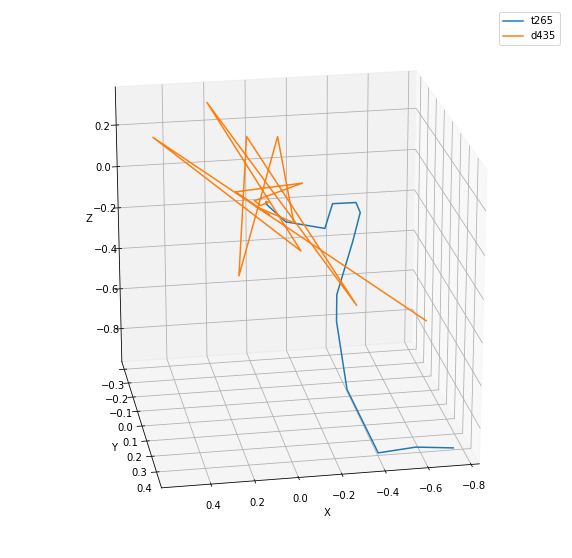

In [131]:
# Graph plot
t265 = np.load('../logs/points_trajectory_T265.npy') #np array coords
d435 = np.load('../logs/points_trajectory_D435.npy')/1 # np array coords
# before = 10
before = d435.shape[0]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(t265[:before, 0], t265[:before, 1], t265[:before, 2], label='t265')
ax.plot(d435[:before, 0], d435[:before, 1], d435[:before, 2], label='d435')
ax.view_init(elev=22, azim=80)
plt.legend()

## Functions

In [132]:
def get_transformation(pose):
    data = pose.get_pose_data()
    data_rot = [float(i.strip('xyzw: ')) for i in str(data.rotation).split(', ')]
    r = R.from_quat(data_rot)
    rotation = np.array(r.as_matrix())
    translation = np.array([float(i.strip('xyzw: ')) for i in str(data.translation).split(', ')])[np.newaxis].T
    T = np.hstack((rotation, translation))
    T = np.vstack((T, np.array([0, 0, 0, 1])))
    return T

In [133]:
get_transformation(t265_frames[0])

array([[ 0.95426662, -0.26579744,  0.13684636, -1.08901   ],
       [ 0.12872294,  0.77844951,  0.61436697,  0.395562  ],
       [-0.26982515, -0.56865463,  0.77706261, -0.911533  ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [134]:
def apply_transformation(transformation, points):
    """

    :param transformation: 4x4 np.array
    :param points: Nx3 np.array
    :return: transformed Nx3 np.array
    """
    if transformation is None or points is None:
        return None
    else:
        coordinates = np.hstack((points, np.ones((points.shape[0], 1))))
        return (transformation @ coordinates.T).T[:, :-1]

In [135]:
def get_coordinates(depth_frame, make_sampling=True, koef = 2**2):
    """
     TODO
    :param make_sampling:
    :return:
    """
    pc = rs.pointcloud()
    if make_sampling:
        decimate = rs.decimation_filter()
        decimate.set_option(rs.option.filter_magnitude, koef)
        depth_frame = decimate.process(depth_frame)

        points = pc.calculate(depth_frame).as_points()
    else:
        points = pc.calculate(depth_frame).as_points()

    coordinates = np.ndarray(buffer=points.get_vertices(), dtype=np.float32, shape=(points.size(), 3))
    coordinates = coordinates[coordinates[:, 2] != 0]

    coordinates = apply_transformation(tm_T265toD435, coordinates)
    return coordinates


In [125]:
get_coordinates(d435_frames[0]).shape

(24127, 3)

In [126]:
def convert_to_pcl(points):
    """
        TODO
    :param points: Nx3
    :return:
    """
    if points is None:
        return None
    else:
        return o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))

In [127]:
convert_to_pcl(get_coordinates(d435_frames[0]))

geometry::PointCloud with 24127 points.

In [ ]:
# TODO this 100%

def get_transformation(self, max_point_pair_dist=0.2, init_guess=np.eye(4)):
    old_point_cloud = self.apply_transformation(self.prev_tm, self.point_cloud)
    old_pcl = self.convert_to_pcl(old_point_cloud) # n-1
    self.point_cloud = self.apply_transformation(self.prev_tm, self.get_coordinates())
    if old_pcl is None:
        self.prev_tm = init_guess
        print("\n\n\n{}\n\n\n".format(init_guess))
        return None

    new_pcl = self.convert_to_pcl(self.point_cloud) # n

    tr_mx = o3d.registration.registration_icp(old_pcl, new_pcl, max_point_pair_dist,
                                              self.prev_tm, o3d.registration.TransformationEstimationPointToPoint())\
        .transformation
    self.prev_tm = tr_mx
    return tr_mx